# INFO 300 Final Project
### Anish Velagapudi and Will Bowers
### 12/10/19

#### Metric Ideas:
- Youtube “Interaction’
    - Function of likes, dislikes, comments (possibly take into account comments/ratings_disabled)
    - Measures how much interaction users had with the content
- Views
- Category (get mapping through XX_category_id.json files)

- Time
    - Trending date
        - Talk about this (our data is already “trending data”, so we’d be looking at what trends most and least amongst already trending videos, not all videos) —> do we want more data?
        
        
- Youtube's definition of "trending"
    - How quickly it generated views (which we don't have, talk about in disucssion)
    - How long the video has been around (does this mean more trending or less trending?)
    - etc.

#### Northern Meteorological Seasons
- Spring: March 1 to May 31
- Summer: June 1 to August 31
- Fall: September 1 to November 30
- Winter: December 1 to February 28 (February 29 on a leap year)

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Preprocessing

In [2]:
# Load all country datasets into DataFrames
US = pd.read_csv('./../youtube-new/USvideos.csv')
CA = pd.read_csv('./../youtube-new/CAvideos.csv', encoding='UTF-8')
DE = pd.read_csv('./../youtube-new/DEvideos.csv', encoding='UTF-8')
FR = pd.read_csv('./../youtube-new/FRvideos.csv', encoding='UTF-8')
GB = pd.read_csv('./../youtube-new/GBvideos.csv', encoding='UTF-8')
IN = pd.read_csv('./../youtube-new/INvideos.csv', encoding='UTF-8')

# Encoding issues with these 4 countries (non-language characters appear, is unreadable)
# Excluding these countries from data analysis for now
JP = pd.read_csv('./../youtube-new/JPvideos.csv', encoding='ISO-8859-1')
KR = pd.read_csv('./../youtube-new/KRvideos.csv', encoding='ISO-8859-1')
MX = pd.read_csv('./../youtube-new/MXvideos.csv', encoding='ISO-8859-1')
RU = pd.read_csv('./../youtube-new/RUvideos.csv', encoding='ISO-8859-1')

all_countries = ['US', 'CA', 'DE', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU']
badly_encoded = ['JP', 'KR', 'MX', 'RU']
country_names = all_countries[0:-len(badly_encoded)]
country_data = [US, CA, DE, FR, GB, IN]

# Below snippet of code prints out the encoding found for the given file.
# for country in country_names:
#     filename = './../youtube-new/' + country + 'videos.csv'
#     with open(filename) as f:
#         print(f)

In [3]:
# Print out how many records and features each dataset has
for i, country in enumerate(country_data):
    print("The " + country_names[i] + " dataset contains " + str(country.shape[0]) + " entries and " + str(country.shape[1]) + " features.")

# Combine all countries into one dataframe
df = pd.DataFrame().append(country_data, ignore_index=True)
print("Our entire dataset contains " + str(df.shape[0]) + " entries and " + str(df.shape[1]) + " features.")

The US dataset contains 40949 entries and 16 features.
The CA dataset contains 40881 entries and 16 features.
The DE dataset contains 40840 entries and 16 features.
The FR dataset contains 40724 entries and 16 features.
The GB dataset contains 38916 entries and 16 features.
The IN dataset contains 37352 entries and 16 features.
Our entire dataset contains 239662 entries and 16 features.


In [4]:
print("The first video was published " + str(df['publish_time'].min()) + " and the last video was published " + str(df['publish_time'].max()))

trending_year_counts = {}
for row in df['trending_date']:
    year = int('20' + row[0:2])  # get year
    trending_year_counts[year] = trending_year_counts.get(year, 0) + 1

published_year_counts = {}
for row in df['publish_time']:
    year = int(row[0:4])  # get year
    published_year_counts[year] = published_year_counts.get(year, 0) + 1

print("\nNumber of videos trending: ")
trending_year_counts_df = pd.DataFrame(data=list(trending_year_counts.items()), columns=['Date', 'Trending Count']).sort_values(by='Date')
print(trending_year_counts_df)

print("\nNumber of videos published: ")
published_year_counts_df = pd.DataFrame(data=list(published_year_counts.items()), columns=['Date', 'Published Count']).sort_values(by='Date')
print(published_year_counts_df)

The first video was published 2006-07-23T08:24:11.000Z and the last video was published 2018-06-14T02:25:38.000Z

Number of videos trending: 
   Date  Trending Count
0  2017           57037
1  2018          182625

Number of videos published: 
    Date  Published Count
11  2006                1
12  2007               37
8   2008               59
6   2009               31
4   2010               57
1   2011              113
3   2012               41
7   2013              122
9   2014              114
2   2015              143
5   2016              127
0   2017            60600
10  2018           178217


In [5]:
# Video categories for all countries are the same, so only need to use US's categories
json = pd.read_json('./../youtube-new/US_category_id.json')

# Get video category id and title. id: video_categories[0], title: video_categories[1]
video_categories = {}
categories = [[item['id'], item['snippet']['title']] for item in json['items']]
for category in categories:
    id = int(category[0])
    name = category[1]
    video_categories[id] = name

print(video_categories)

{1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 17: 'Sports', 18: 'Short Movies', 19: 'Travel & Events', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education', 28: 'Science & Technology', 29: 'Nonprofits & Activism', 30: 'Movies', 31: 'Anime/Animation', 32: 'Action/Adventure', 33: 'Classics', 34: 'Comedy', 35: 'Documentary', 36: 'Drama', 37: 'Family', 38: 'Foreign', 39: 'Horror', 40: 'Sci-Fi/Fantasy', 41: 'Thriller', 42: 'Shorts', 43: 'Shows', 44: 'Trailers'}


## Data Analysis

### Select Features and Filter Data

In [6]:
basic_features = ['views', 'likes', 'dislikes', 'comment_count']
exclude_features = ['thumbnail_link', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed', 'description']

num_records_total = len(df)

# Filter out videos that have comments/ratings disabled or got removed
# and drop all excluded feature columns
df = df[(df[exclude_features[1]] == False) & 
        (df[exclude_features[2]] == False) &
        (df[exclude_features[3]] == False)].drop(columns=exclude_features)

# 6713 records filtered. We could have used this intersection of data for further analysis
# but a sample size of ~7k out of ~240k might be too small to yield interesting findings
num_records_filtered = num_records_total - len(df)
print("Removed %d records out of %d total." %(num_records_filtered, num_records_total))
print("New total of %d records" %(num_records_total - num_records_filtered))

# Preview
df.iloc[0:1]

Removed 6713 records out of 239662 total.
New total of 232949 records


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954


### Normalizing features (removed)

Might want to normalize features to have more equal weightage between basic features in the combined metric.
```
def normalize(col):
    largest = col.max()
    if largest == 0:
        return col
    return col / largest

for feature in basic_features:
    df[feature] = normalize(df[feature])
  
# Normalized preview
df[['title'] + basic_features][0:5]
```

### Creating Metrics

In [7]:
# Add season column to data
df['season'] = ""

# Extract month from date string
formatted_date = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
month = formatted_date.dt.month

# Assign a season to each record
df.loc[(month == 3) | (month == 4) | (month == 5), 'season'] = 'spring'
df.loc[(month == 6) | (month == 7) | (month == 8), 'season'] = 'summer'
df.loc[(month == 9) | (month == 10) | (month == 11), 'season'] = 'fall'
df.loc[(month == 12) | (month == 1) | (month == 2), 'season'] = 'winter'

# "Split" by season for convenience
spring = df[df['season'] == 'spring']
summer = df[df['season'] == 'summer']
fall = df[df['season'] == 'fall']
winter = df[df['season'] == 'winter']

season_dfs = [spring, summer, fall, winter]
seasons = ['spring', 'summer', 'fall', 'winter']

In [8]:
season_counts = {}
for i, season_df in enumerate(season_dfs):
    print("# videos in %s is %d" %(seasons[i], len(season_df)))
    season_counts[seasons[i]] = len(season_df)
    
seasons_sorted_by_count = sorted(season_counts, key=season_counts.get, reverse=True)
print("Seasons sorted by count (most to least): " + str(seasons_sorted_by_count))

# videos in spring is 96879
# videos in summer is 15690
# videos in fall is 19686
# videos in winter is 100694
Seasons sorted by count (most to least): ['winter', 'spring', 'fall', 'summer']


In [9]:
# Months 7 - 10 don't have ANY trending videos. This is strange and likely not the reality,
# but it's what our data says. Mention this in limitations. Below is proof that these months
# have no trending videos.
d = df['trending_date'].unique()
video_count_by_month = {}
for date in d:
    year = int(date[-2:])  # get month
    video_count_by_month[year] = video_count_by_month.get(year, 0) + 1
video_count_by_month

months_without_videos = [x for x in range(1, 13) if x not in list(video_count_by_month)]
print(months_without_videos)

# Double check: Selecting all records whose trending date is any of the months in question
r_months = df[df['trending_date'].str.contains('0[789]$|10$')] # 12, 01, 02
print(len(r_months))

[7, 8, 9, 10]
0


In [10]:
# Retrieves the title of the video with the *maximum* value for a given feature and season
def get_max_metric(feature, season_df):
    max_metric = season_df[season_df[feature] == season_df[feature].max()]
    return max_metric['title'].to_string(index=False)

# Retrieves the title of the video with the *minimum* value for a given feature and season
def get_min_metric(feature, season_df):
    min_metric = season_df[season_df[feature] == season_df[feature].min()]
    return min_metric['title'].to_string(index=False)

# Prints a summary of the videos with the max and min value for a given feature and season
def print_extremes(feature, season_df, print_min=False):
    print("The video(s) with the most %s is %s" %(feature, get_max_metric(feature, season_df)))
    
    # Option to print min because there are often lots of videos with 0 dislikes, which clutters output
    if (print_min):
        print("The video(s) with the fewest %s is %s" %(feature, get_min_metric(feature, season_df)))
    print()

# Print spring-time extremes for views, likes, dislikes, comments
for metric in basic_features:
    print_extremes(metric, spring)

The video(s) with the most views is Nicky Jam x J. Balvin - X (EQUIS) | Video Ofic...

The video(s) with the most likes is BTS (방탄소년단) 'FAKE LOVE' Official MV
BTS (방탄소년단) 'FAKE LOVE' Official MV

The video(s) with the most dislikes is Netta - Toy - Israel - LIVE - Grand Final - Eu...
Netta - Toy - Israel - LIVE - Grand Final - Eu...

The video(s) with the most comment_count is BTS (방탄소년단) 'FAKE LOVE' Official MV
BTS (방탄소년단) 'FAKE LOVE' Official MV



In [11]:
# Calculates the combined metric and adds it to the given df as a column
def calculate_combined_metric(df):
    df['metric'] = np.zeros(len(df), dtype=int)
    for feature in basic_features:
        df['metric'] += df[feature]

# Get top 3 unique videos (same video often trends for multiple days and comes up as top X)
def get_combined_metric_topN(df, n):
    calculate_combined_metric(df)
    sorted_metric = df.sort_values(by='metric', ascending=False)
    topN_set = set()
    topN = pd.DataFrame()
    i = 0
    while (i < len(sorted_metric) and len(topN_set) < n):
        row = sorted_metric.iloc[i]
        if (row['title'] not in topN_set):
            topN_set.add(row['title'])
            topN = topN.append(row, ignore_index=True)[df.columns.tolist()]
        i += 1
    return topN

# Returns a list of the titles of all the videos in the given df
def get_titles(df):
    return list(df['title'])

print("The top 3 videos with the highest combined metrics are %s" %(get_titles(get_combined_metric_topN(df, 3))))

The top 3 videos with the highest combined metrics are ['Nicky Jam x J. Balvin - X (EQUIS) | Video Oficial | Prod. Afro Bros & Jeon', 'Te Bote Remix - Casper, Nio García, Darell, Nicky Jam, Bad Bunny, Ozuna | Video Oficial', 'Bad Bunny - Amorfoda | Video Oficial']


In [12]:
# Function to get the category name of a record
def category(record):
    return video_categories[record['category_id']]

def category_name(cat_id):
    return video_categories[cat_id]

In [13]:
category_groups = df.groupby('category_id').groups

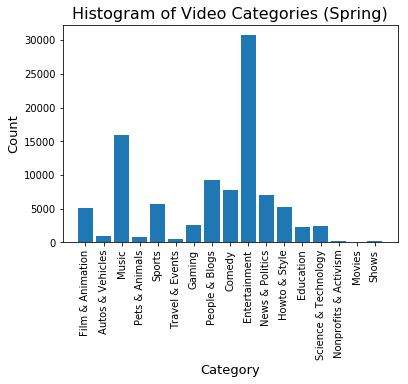

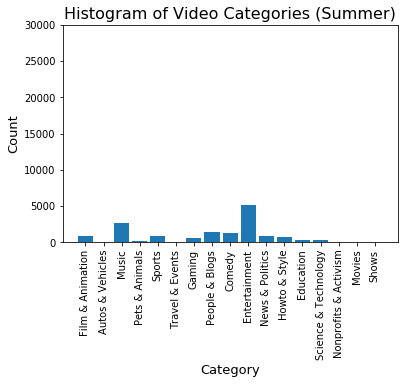

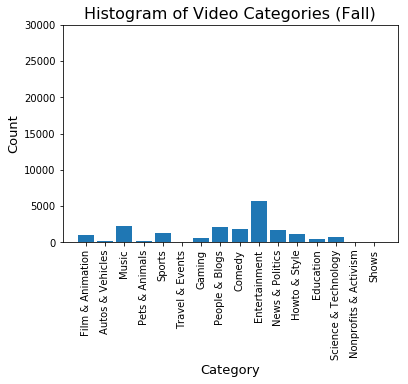

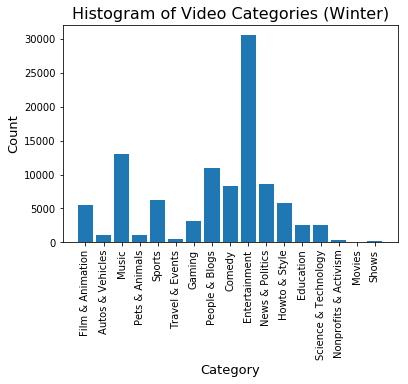

In [14]:
# Creates a bar graph of Category by Combined Metric for a given season
def create_bar_graph(season_df):
    # spring_top3 = get_combined_metric_topN(spring, 3)
    # spring_top3
    season = season_df.iloc[0]['season'].capitalize()
    category_groups = season_df.groupby('category_id').groups
    for item in category_groups:
        category_groups[item] = len(category_groups[item])

    cat_names = [category_name(x) for x in category_groups]
    values = list(category_groups.values())

    fig, ax = plt.subplots()
    x_axis = np.arange(len(category_groups)) * 1.2
    width = 1

    rects = ax.bar(x_axis, values, width, label='Category')

    ax.set_ylabel('Count', fontsize=13)
    ax.set_xlabel('Category', fontsize=13)
    ax.set_title('Histogram of Video Categories (' + season + ')', fontsize=16)
    ax.set_title
    ax.set_yticks([0, 5000, 10000, 15000, 20000, 25000, 30000])
    ax.set_xticks(x_axis)
    ax.set_xticklabels(cat_names)
    # plt.xticks(x_axis, cat_names)  # does the same thing as the above 2 lines
    plt.xticks(rotation='vertical')
    plt.figure(figsize=(17, 17))
    plt.show()

for season_df in season_dfs:
    create_bar_graph(season_df)

In [16]:
# get total trending metric per day for each category and plot the top 3 categories over time

year = formatted_date.dt.year

df_2017 = df.loc[(year == 2017)]
df_2018 = df.loc[(year == 2018)]

cat_agg_metrics_17 = df_2017.groupby(by='category_id')['metric'].sum().sort_values(ascending=False)
cat_agg_metrics_18 = df_2018.groupby(by='category_id')['metric'].sum().sort_values(ascending=False)
# top3: 24 (Entertainment), 10 (Music), 23 (Comedy)
top3_categories_17 = cat_agg_metrics_17[0:3]
# top3: 10 (Music), 24 (Entertainment), 1 (Film & Animation)
top3_categories_18 = cat_agg_metrics_18[0:3]

In [17]:
day_agg_metrics_17 = df_2017.groupby(by=['category_id', 'trending_date'], as_index=False)['metric'].sum()
day_agg_metrics_18 = df_2018.groupby(by=['category_id', 'trending_date'], as_index=False)['metric'].sum()

cat_id_17 = day_agg_metrics_17['category_id']
cat_id_18 = day_agg_metrics_18['category_id']

top3_17_mask = (cat_id_17 == 24) | (cat_id_17 == 10) | (cat_id_17 == 23)
top3_18_mask = (cat_id_18 == 10) | (cat_id_18 == 24) | (cat_id_18 == 1)

day_agg_metrics_17 = day_agg_metrics_17.loc[top3_17_mask]
day_agg_metrics_18 = day_agg_metrics_18.loc[top3_18_mask]

day_agg_metrics_17_entertainment = day_agg_metrics_17[day_agg_metrics_17['category_id'] == 24]
day_agg_metrics_17_music = day_agg_metrics_17[day_agg_metrics_17['category_id'] == 10]
day_agg_metrics_17_comedy = day_agg_metrics_17[day_agg_metrics_17['category_id'] == 23]

day_agg_metrics_18_music = day_agg_metrics_18[day_agg_metrics_18['category_id'] == 10]
day_agg_metrics_18_entertainment = day_agg_metrics_18[day_agg_metrics_18['category_id'] == 24]
day_agg_metrics_18_film = day_agg_metrics_18[day_agg_metrics_18['category_id'] == 1]

In [18]:
def prepare_year_data_for_plot(masked_agg_metric_df):
    masked_agg_metric_df['day'] = pd.to_datetime(masked_agg_metric_df['trending_date'], format='%y.%d.%m').dt.day
    masked_agg_metric_df['month'] = pd.to_datetime(masked_agg_metric_df['trending_date'], format='%y.%d.%m').dt.month
    masked_agg_metric_df = add_sequential_time_col(masked_agg_metric_df)
    masked_agg_metric_df['category_id'] = masked_agg_metric_df['category_id'].apply(lambda x: category_name(x))
    return masked_agg_metric_df
    
def add_sequential_time_col(agg_metric_df):
    agg_metric_df = agg_metric_df.sort_values(by=['month', 'day'])
    agg_metric_df['x_time'] = np.arange(len(agg_metric_df))
    return agg_metric_df


day_agg_metrics_17_entertainment = prepare_year_data_for_plot(day_agg_metrics_17_entertainment)
day_agg_metrics_17_music = prepare_year_data_for_plot(day_agg_metrics_17_music)
day_agg_metrics_17_comedy = prepare_year_data_for_plot(day_agg_metrics_17_comedy)

day_agg_metrics_18_music = prepare_year_data_for_plot(day_agg_metrics_18_music)
day_agg_metrics_18_entertainment = prepare_year_data_for_plot(day_agg_metrics_18_entertainment)
day_agg_metrics_18_film = prepare_year_data_for_plot(day_agg_metrics_18_film)

#  Format of above dfs

#         category_id   	trending_date   	metric  	day 	month 	x_time
#       	Music 	           17.14.11 	  547657996 	14  	11  	0

/Users/anishvelagapudi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/anishvelagapudi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


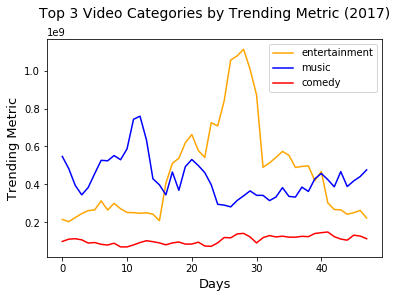

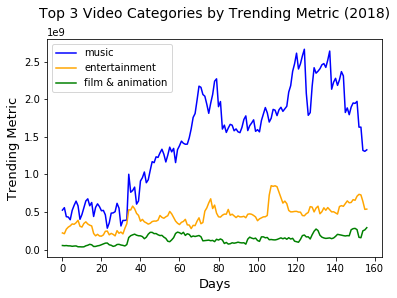

In [19]:
#  Format of dfs to plot

#         category_id 	trending_date 	metric  	day 	month 	x_time
# 109 	Music 	           17.14.11 	547657996 	14  	11  	0

fig, ax = plt.subplots()
ax.set_ylabel('Trending Metric', fontsize=13)
ax.set_xlabel('Days', fontsize=13)
ax.set_title('Top 3 Video Categories by Trending Metric (2017)', fontsize=14)
ttl = ax.title
ttl.set_position([.5, 1.07])

plt.plot('x_time', 'metric', data=day_agg_metrics_17_entertainment, label='entertainment', color='orange')
plt.plot('x_time', 'metric', data=day_agg_metrics_17_music, label='music', color='blue')
plt.plot('x_time', 'metric', data=day_agg_metrics_17_comedy, label='comedy', color='red')
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.set_ylabel('Trending Metric', fontsize=13)
ax.set_xlabel('Days', fontsize=13)
ax.set_title('Top 3 Video Categories by Trending Metric (2018)', fontsize=14)
ttl = ax.title
ttl.set_position([.5, 1.07])

plt.plot('x_time', 'metric', data=day_agg_metrics_18_music, label='music', color='blue')
plt.plot('x_time', 'metric', data=day_agg_metrics_18_entertainment, label='entertainment', color='orange')
plt.plot('x_time', 'metric', data=day_agg_metrics_18_film, label='film & animation', color='green')
plt.legend()
plt.show()

In [20]:
# Find out which months are the first and last ones used in the above graphs

print(pd.to_datetime(day_agg_metrics_17_entertainment['trending_date'], format='%y.%d.%m').dt.month.min())
print(pd.to_datetime(day_agg_metrics_17_entertainment['trending_date'], format='%y.%d.%m').dt.month.max())

print(pd.to_datetime(day_agg_metrics_18_entertainment['trending_date'], format='%y.%d.%m').dt.month.min())
print(pd.to_datetime(day_agg_metrics_18_entertainment['trending_date'], format='%y.%d.%m').dt.month.max())

11
12
1
6


In [316]:
top3_2017 = pd.DataFrame()
top3_2018 = pd.DataFrame()

year = formatted_date.dt.year

spring_2017 = spring.loc[(year == 2017)]
summer_2017 = summer.loc[(year == 2017)]
fall_2017 = fall.loc[(year == 2017)]
winter_2017 = winter.loc[(year == 2017)]

spring_2018 = spring.loc[(year == 2018)]
summer_2018 = summer.loc[(year == 2018)]
fall_2018 = fall.loc[(year == 2018)]
winter_2018 = winter.loc[(year == 2018)]

season_dfs_2017 = [spring_2017, summer_2017, fall_2017, winter_2017]
season_dfs_2018 = [spring_2018, summer_2018, fall_2018, winter_2018]

for season_df in season_dfs_2017:
    top3_2017 = top3_2017.append(get_combined_metric_topN(season_df, 3), ignore_index=True)
    
for season_df in season_dfs_2018:
    top3_2018 = top3_2018.append(get_combined_metric_topN(season_df, 3), ignore_index=True)

/Users/anishvelagapudi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/anishvelagapudi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [306]:
winter_values = top3_2017[top3_2017['season'] == 'winter']['metric']
winter_values
top3_2017['metric']

0    141326700.0
1    104640661.0
2     41768423.0
3    175795958.0
4    146376559.0
5    103799336.0
Name: metric, dtype: float64

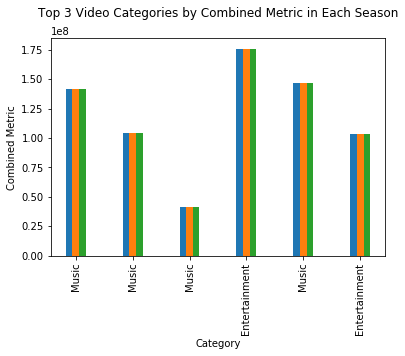

In [314]:

# category_groups = top3_2017.groupby('category_id').groups
# print(category_groups)
cat_names = top3_2017['category_id'].apply(lambda x: category_name(x))
values = top3_2017['metric']

fig, ax = plt.subplots()
x_axis = np.arange(len(cat_names)) * 3
width = 0.35

# x_axis = np.arange(len(spring_category_groups))

rects1 = ax.bar(x_axis - width, values, width, label='#1 Video')
rects2 = ax.bar(x_axis,         values, width, label='#2 Video')
rects3 = ax.bar(x_axis + width, values, width, label='#3 Video')


# spring_values = top3_2017[top3_2017['season'] == 'spring']['metric']
# summer_values = top3_2017[top3_2017['season'] == 'summer']['metric']
# fall_values = top3_2017[top3_2017['season'] == 'fall']['metric']
# winter_values = top3_2017[top3_2017['season'] == 'winter']['metric']


# fig, ax = plt.subplots()
# x_axis = np.arange(len(cat_names)) * 3
# width = 0.35

# # x_axis = np.arange(len(spring_category_groups))

# rects1 = ax.bar(x_axis - width, winter_values, width, label='#1 Video')
# rects2 = ax.bar(x_axis,         winter_values, width, label='#2 Video')
# rects3 = ax.bar(x_axis + width, fall_values, width, label='#3 Video')



# rects = ax.bar(x_axis, values, width, label='Category')

ax.set_ylabel('Combined Metric')
ax.set_xlabel('Category')
ax.set_title('Top 3 Video Categories by Combined Metric in Each Season')

ttl = ax.title
ttl.set_position([.5, 1.07])

# ax.set_yticks([0, 500000, 5000000, 50000000, 100000000, 150000000, 200000000])
ax.set_xticks(x_axis)
ax.set_xticklabels(cat_names)
# plt.xticks(x_axis, cat_names)  # does the same thing as the above 2 lines
plt.xticks(rotation='vertical')
plt.show()